## The wine dataset
The wine dataset from University of California Irvine (UCI) is a popular benchmark dataset for classification tasks. The dataset is composed by 13 features and 1 array of targets, containing the class ID for each wine. Features are are the results of a chemical analysis of wines grown in the same region in Italy but derived from three different cultivars. We have 3 cultivars, identifyied with the labels '0', '1', '2'.

The analysis determined the quantities of 13 constituents found in each of the three types of wines.
- Alcohol
- Malic acid
- Ash
- Alcalinity of ash
- Magnesium
- Total phenols
- Flavanoids
- Nonflavanoid phenols
- Proanthocyanins
- Color intensity
- Hue
- OD280/OD315 of diluted wines
- Proline

The aim of this study is to buid some classifiers using the simplest models in the 'sklearn' module, point out the most relevant properties/advanteages and compare he models results.

## Problem statement
Single output, multi-label classification problem with more numeric input features. All inputs are continuous variables. There is 1 discrete target variable to be predicted, given the inputs.

## Libraries
For this project, I used many modules from the 'sklearn' library. Matplotlib and especially Seaborn are used to simplify the plotting tasks.

In [1]:
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.cm import get_cmap
import pandas as pd
import numpy as np

from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split, validation_curve, cross_val_score, ParameterGrid, GridSearchCV
from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline

## Import the dataset
The UCI wine dataset is contained in the sklearn module, since it's a common playground for testing classification algorithms.
One could also download the original csv file from https://archive.ics.uci.edu/ml/datasets/wine

Thanks to the embedded 'load_wine' function, it is possible to import the dataset in multiple formats. For my purpose, I decided to import the inputs and targets dataframes separately. Note that the first object is an ususal pandas dataframe, while the second is a pandas series.

I decided to call X the features dataframes, after renaming one column label, to improve readability. The target series has been re-framed to a pandas dataframe, with column name 'wine_groups' 

The X dataframe has M = 13 columns and N = 178 rows.

In [2]:
(inputs, target) = load_wine(return_X_y=True, as_frame = True)
X = inputs.rename(columns = {"od280/od315_of_diluted_wines":"protein_purity_index"})
y = target.to_frame(name = "wine_group")

# let's see how the features dataframe looks like
X

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,protein_purity_index,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,13.71,5.65,2.45,20.5,95.0,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740.0
174,13.40,3.91,2.48,23.0,102.0,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750.0
175,13.27,4.28,2.26,20.0,120.0,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835.0
176,13.17,2.59,2.37,20.0,120.0,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840.0


## Features correlations 
Before starting to build the classificators, it's useful to look for correlations between the inputs. One popular way is to compute the correlation matrix, which is a N x N matrix containing the Pearson's correlation coefficient for each couple of features. 

This results in a symmetric matrix, due to the mathematical properties of the variance and covariance operators, which compare in the correlation coefficient computation.

The easiest way to plot the correlation matrix is via a seaborn heatmap. To improve the visualization quality, I used only the lower diagonal set of values of the matrix. 

The following function renders the correlation analysis more easy to understand.

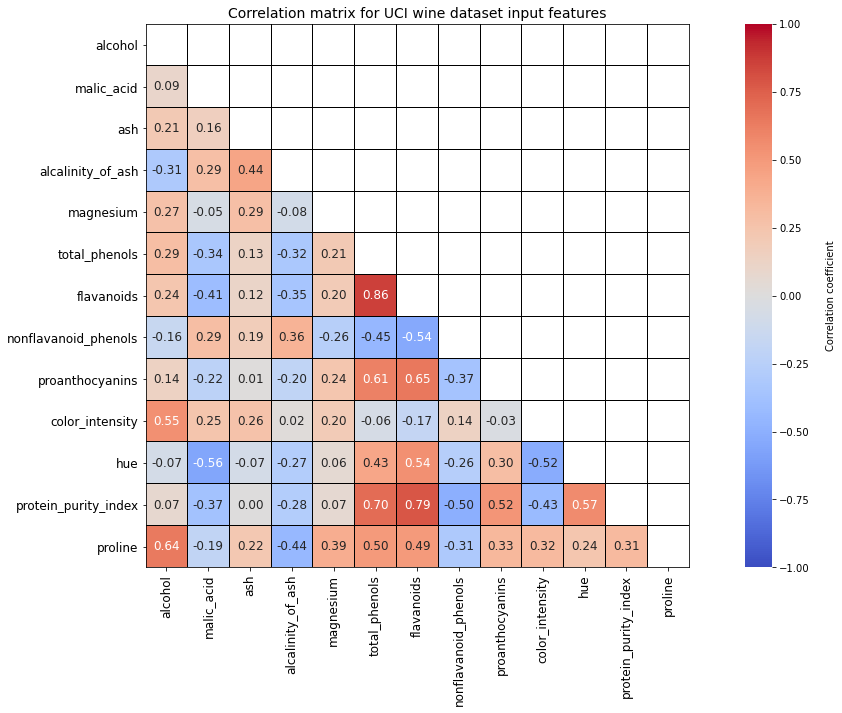

In [3]:
def plot_correlation_heatmap(df, title = "", decimals = 2):
    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(df.corr(), dtype=bool))

    fig, ax = plt.subplots(figsize=(20, 10))
    
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(df.corr(), mask=mask, cmap=get_cmap('coolwarm'), center=0, annot = True, vmin = -1, vmax = 1,
                fmt = ".{}f".format(decimals), square=True, linecolor='black', linewidths=0.01, 
                annot_kws={"size":12}, cbar_kws={'label': '\nCorrelation coefficient'})
    
    plt.title(title, fontsize = 14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    # make frame visible
    for _, spine in plt.gca().spines.items():
        spine.set_visible(True)

plot_correlation_heatmap(X, title="Correlation matrix for UCI wine dataset input features")

What can we notice from the figure above? Some features seem to be strongly correlated in a positive way, like:
- total phenoles and flavonoids
- total phenoles and protein purity index
- flavanoids and  protein purity index
- proanthocyanins with total phenoles and flavanoids,
- proline and alcohol

This may suggest that these couples represent the same underlaying phaenomena, since the growth of one is associated with a correspondent growt of the paired one.

At the same time, other feature couples are strongly uncorrelated (look at the i,j items close to 0), which suggest that those variables should be considerated as linearly unrelated to each other.

## Recongize low-variant features
Looking at these quantities can also be useful when trying to understand the underlaying distribution of the inputs (which can be considered as random variables). More in detail, the variance computation gives us an insight of how much the samples are spread around the average value.

Remember that the target column assigns an ID label to each wine, and we have many wines that belong to each category, with their values of the X input features. The core point here is that an input feature which samples are concentrated around the mean, regardless from the associated wine label, can be approximated as a constant and is less important for the devinition of the target label. 
In easier words: how can this feature help to distinguish the wine type, if it's more or less the same for all wines? 

Note that first we computed the standard deviation (the square root of the variance), because it is expressed in the same 'unit' of the original variable, like the mean does. In few words, the std outputs a handier result, but refers to the same underlaying concept of the var. Then we divided the std for the mean, obtaining the coefficient of variation.

In [4]:
# Following lines build up a dataframe containing the average value and the standard deviation for each input feature.
mean_and_variance_df = pd.DataFrame(data = [X.mean(), X.std()]).T # Note the transpose operator at the end
mean_and_variance_df.columns = ["mean", "std"]
mean_and_variance_df["coeff variation"] = mean_and_variance_df["std"]/mean_and_variance_df["mean"]
mean_and_variance_df.sort_values("coeff variation", ascending = False, inplace = True) # sort based on the higher CV
mean_and_variance_df

,mean,std,coeff variation
flavanoids,2.029270,0.998859,0.492226
malic_acid,2.336348,1.117146,0.478159
color_intensity,5.058090,2.318286,0.458332
proline,746.893258,314.907474,0.421623
proanthocyanins,1.590899,0.572359,0.359771
nonflavanoid_phenols,0.361854,0.124453,0.343933
total_phenols,2.295112,0.625851,0.272689
protein_purity_index,2.611685,0.709990,0.271851
hue,0.957449,0.228572,0.238730
alcalinity_of_ash,19.494944,3.339564,0.171304


We can notice that alcohol, ash, magnesium, alcalinity of ash are very 'low-spread' variables, which means that their samples are more likely to be concentrated around the average value. On the other hand, flavanoids, malic acid, color intensity, proline show a more significant deviation from the mean.

We expect that the set composed by the 4 features, i.e. ["flavanoids", "malic acid", "color intensity", "proline"] carrys more information than oder ones. By contrast, we can clearly see that at least alcohol (which value is concentrated around 13%) and ash content seem to be more or less the same, so we can infer that they do not carry important information, for the purpose of deciding the wine type.

## Class imbalance
A common characteristic of classification problems is that the raw dataset, in general, does not contain exactly the same amount of samples for each classification label. This fact, known as 'class imbalance', can be neglected if the ratio of samples for each category is more ore less the same, but in this case - as shown by the below dataframe - we ahve to take into account that class '2' contains less wines.
There are many strategies available to overcome the class imbalance problem. In this study, since the clas distribution is not so heavily imbalanced (i.e. we don't have 95% of wines labelled '0', 4% '1' and only 1% '2'), we will use the 'balanced' option when training classificators, which assigns a weight to each sample, according to the frequency of the sample label in the training set, to increase the relative importance of the samples labelled '2', in the following computations.

In [5]:
# I wrapped the computation around a function, to make it easier to call it more times on different sub-sets
def compute_class_imbalance(df, decimals = 2):
    value_counts_df = pd.DataFrame(data = df.value_counts().sort_index(), columns = ["value_counts"])
    value_counts_df["fraction_of_items_per_class"] = (value_counts_df["value_counts"]/(value_counts_df["value_counts"].sum())).round(2)
    return value_counts_df

compute_class_imbalance(y)


,value_counts,fraction_of_items_per_class
wine_group,,
0,59,0.33
1,71,0.40
2,48,0.27


## Training set and testing set
We need to split hte whole dataset in 2 subsets: the trauining and the testing set. No need of explicitly create a held-out validation set from the training set, since we will use cross validation strategies, which internally use some samples (e.g. K-fold technique) as validation set, to score the models and select the best one.

A test size of 25% samples can be enough for many applications, but this choice is arbitrary. Note that one could also select the training oir testin size in terms of number of rows (= samples) instead of providing the percentage.

In [6]:
# here the option stratified = None is activated per default. 
# Stratified sampling is used to preserve more or less the class frequency in the samples.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25) 

# Let's look at the shapes of the training and testing set (input features)
print("Training set has: {} rows and {} columns,\nTesting set has: {} rows and {} columns.".format(X_train.shape[0], 
                                                                                                   X_train.shape[1], 
                                                                                                   X_test.shape[0],
                                                                                                   X_test.shape[1]))

Training set has: 133 rows and 13 columns,
Testing set has: 45 rows and 13 columns.


It's important to perform this split now, so that each model type will be trained and tested on the same sub-sets. More in detail, I want to test them on the same held-out samples. 

In [7]:
# Check if the class proportion has been respected while splitting the whole dataset.

compute_class_imbalance(y).join(compute_class_imbalance(y_test), lsuffix = "_whole_set", rsuffix = "_testing_set")

,value_counts_whole_set,fraction_of_items_per_class_whole_set,value_counts_testing_set,fraction_of_items_per_class_testing_set
wine_group,,,,
0,59,0.33,12,0.27
1,71,0.40,18,0.40
2,48,0.27,15,0.33


## Rescaling the input fatures
Since the input values have different magnitude, a good practice is to rescale them. There are many strategies that can be implemented in sklearn, like standardization, mapping to known distributions etc.
Here we will use the easiest one: features min-max rescaling.

An important note on the scaler fitting: like the following mathematical models, the scaler should be trained providing only the training samples (for both input features and target values, so 2 matrices or dataframes), not the whole dataset, which contains also the samples used for testing. Otherwise we would use some information contained in the held-out set for data transformation purpose. This would cause a so-called 'data leakage' issue.

For a classification problem like this, there is no need of rescaling the target array, since it's handled as a categorical quantity, even though its values are integer types. For regression problems, it is often desirable to scale or transform both the input and the target variables. One could use a sklearn.compose.TransformedTargetRegresso class, fit and transforming using y_train.

In [8]:
# fit the scaler with the training set and then transform the inputs
scaler = MinMaxScaler()
# first we fit the scaler on the training set (X_train, y_train) and transform the input features X_train
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train, y_train), columns = X_train.columns)
X_train_scaled

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,protein_purity_index,proline
0,0.623684,0.762846,0.802139,0.742268,0.518519,0.344828,0.130802,0.250000,0.220820,0.616041,0.111111,0.254902,0.277384
1,0.313158,0.108696,0.310160,0.432990,0.271605,0.475862,0.358650,0.480769,0.526814,0.121160,0.273504,0.686275,0.026793
2,0.321053,0.620553,0.449198,0.407216,0.518519,0.137931,0.092827,0.288462,0.230284,0.591297,0.094017,0.286275,0.454689
3,0.671053,0.363636,0.711230,0.716495,0.432099,0.196552,0.105485,0.480769,0.356467,0.629693,0.170940,0.207843,0.371946
4,0.650000,0.211462,0.668449,0.484536,0.320988,0.534483,0.478903,0.269231,0.394322,0.191126,0.495726,1.000000,0.446809
...,...,...,...,...,...,...,...,...,...,...,...,...,...
128,0.352632,0.077075,0.427807,0.432990,0.209877,0.868966,0.582278,0.096154,0.460568,0.270478,0.581197,0.627451,0.111899
129,0.352632,0.175889,0.502674,0.716495,0.222222,0.427586,0.445148,0.500000,0.470032,0.071672,0.299145,0.592157,0.050433
130,0.681579,0.832016,0.529412,0.484536,0.271605,0.351724,0.097046,0.634615,0.192429,0.266212,0.316239,0.305882,0.214342
131,0.823684,0.349802,0.598930,0.484536,0.259259,0.241379,0.075949,0.576923,0.261830,0.718430,0.068376,0.172549,0.301024


For what concerns the testing set (X_test, y_test) we apply only the 'transform' method of the scaler.

In [9]:
# rescale the testing set but without fitting the scaler again
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns)

Now we have 2 sets: the first tuple (X_train_scaled, y_train_scaled), and the second tuple (X_test_scaled, y_test_scaled). 
We will usse these dataframes in the following machine learning tasks, for models fitting, evaluation and testing phases.

## Decision tree
The first model deployed in this comparative study is a simple decision tree. Decision Trees are a non-parametric, supervised learning methods used for both classification and regression. Here we will look at the classification tree implementation (the DecisionTreeClassifier) class.

A decision tree predicts the value of a target variable by learning simple decision rules inferred from the data features. there are no embedded parameters to be fitted (like the coefficients in a linear/polynomial regression task). Data used for training are recursively split, using 2 available criteria  to measure the quality of a split. Supported criteria are Gini impurity or information entropy.

The model complexity is determined by the number of splits, or equivalently, by the number of max leaf nodes.

For this study we used the default parameters implemented in the sklearn class. For example, 'max_features' was set to None, in order to force the tree to consider all input features (and not only a cubset of features). Class weights are introduced to take into account class imbalance.

In [10]:
decision_tree = DecisionTreeClassifier(class_weight = "balanced")
decision_tree.fit(X_train, y_train["wine_group"])

DecisionTreeClassifier(class_weight='balanced')

There are many ways to perform hyperparameters tuning, and to assess the validation score. In this case, since the parameters space is reduced (we only have 1 parameter to be tuned), it's more handy to use the 'sklearn' function 'validation_curve' get the training and validation scores as functions of the parameter choices.

To be able to call it again with a different model, I wrapped 'validation_curve' into the custom function below. This resturns the validation curve an the best parameter choice.

Note that 'validation_curve' only works if one has to tune 1 hyperparameter. In general, with a more complex and multi-dimensional search grid, it's better to perform a parameter search using 'sklearn' dedicated modules, and plotting the results only for a limited number of parameters.

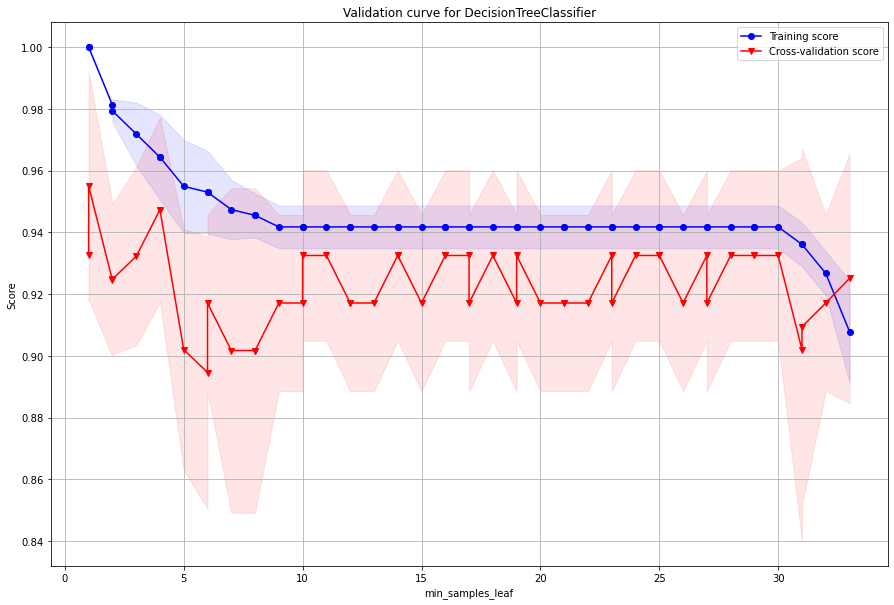

In [11]:
def plot_cv_curve(model, X, y, param_name, param_range):
    train_scores, valid_scores = validation_curve(model, X_train.values, y.values, param_name = param_name, 
                                              param_range = param_range)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    valid_scores_mean = np.mean(valid_scores, axis=1)
    valid_scores_std = np.std(valid_scores, axis=1)
    
    fig, ax = plt.subplots(figsize = (15, 10))
    plt.title("Validation curve for {}".format(type(model).__name__))
    plt.xlabel(param_name)
    plt.ylabel("Score")
    ax.plot(param_range, train_scores_mean, label="Training score", color="blue", marker = "o")
    ax.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std,
        alpha=0.1, color="blue")
    
    ax.plot(param_range, valid_scores_mean, label="Cross-validation score", color="red", marker = "v")
    ax.fill_between(param_range, valid_scores_mean - valid_scores_std, valid_scores_mean + valid_scores_std,
        alpha=0.1,color="red")

    plt.legend(loc="best")
    plt.grid(which = "both")
    
    best_param = train_scores_mean.max()
    return fig, best_param

fig, best_param = plot_cv_curve(decision_tree, X_train, y_train["wine_group"], 
                              param_name = "min_samples_leaf", 
                              param_range = np.linspace(1, compute_class_imbalance(y_train)["value_counts"].min(), 
                                                        dtype = int))

In [12]:
print(best_param)

1.0


A note on the datasets used for training and testing the tree: since this mathematical models adopt a data separation strategy, basically finding and applying a ordered set of if-then statements, one feature at a time, we don't need to rescale the input features. Indeed, the input arrays are held separated during the training phase, so the features different magnitude does not affect the final results.

## Plotting the decision tree
The easiest way of plotting the decision tree is to use the 'plot_tree' function from the DecisionTreeClassifier.

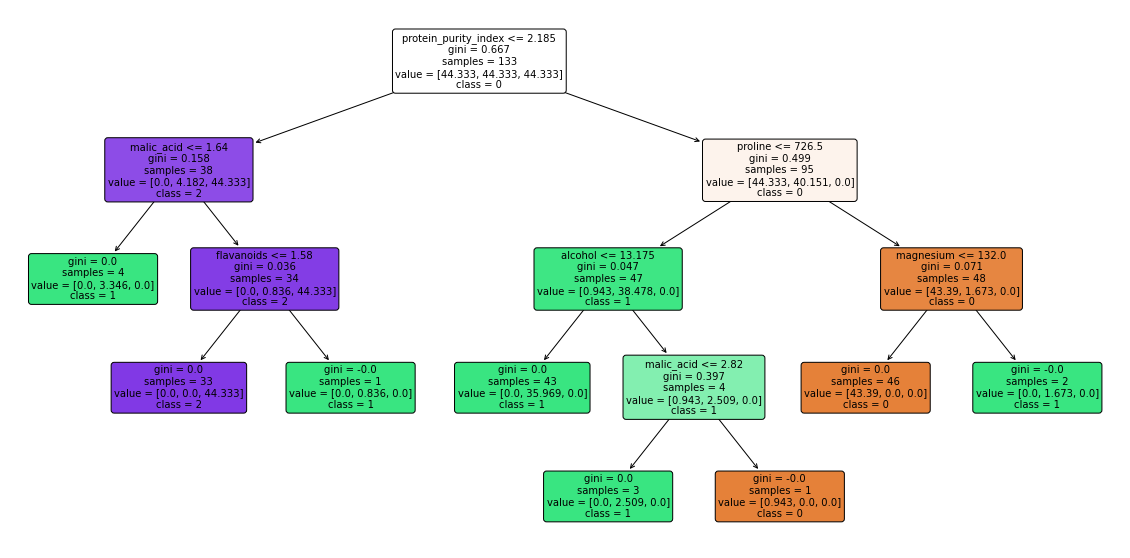

In [13]:
fig = plt.figure(figsize=(20,10))
annotations = plot_tree(decision_tree, feature_names=X.columns.to_list(), 
                        class_names=np.unique(y["wine_group"].map(str)), filled=True, ax = plt.gca(), 
                        rounded =True, fontsize = 10)

## Feature importance estimation
A very useful usage of the decision tree classifier is the possibility of getting an estimation of the feature importances, considering all features that have been used to train the model. The importance of a feature is computed as the weighted (between 0 and 1) total reduction of the criterion brought by that feature. It is also known as the Gini importance.

'Feature importances' is an attribut of the fitted classifier, so this array can be used as data of 'feature importance dtaframe' like the on ebelow. We can sort the dataframe by importance and obtain a list of the most important imputs.

In [14]:
df_feature_importance = pd.DataFrame(index = range(0, len(X.columns.to_list())),                                    
                                     data = zip(X.columns.to_list(), decision_tree.feature_importances_), 
                                     columns = ["feature name", "feature importance"]).sort_values(by = "feature importance", 
                                                                                                   ascending = False).round(3)
df_feature_importance

,feature name,feature importance
11,protein_purity_index,0.439
12,proline,0.418
1,malic_acid,0.083
4,magnesium,0.036
6,flavanoids,0.019
0,alcohol,0.005
2,ash,0.000
3,alcalinity_of_ash,0.000
5,total_phenols,0.000
7,nonflavanoid_phenols,0.000


We can also plot a bar chart like the following one, to display the weighted importance of the features.

What can we notice? According to the feature importance ranking, following features carry the most valuable information, that is used to classify the wines:
- flavonoids
- proline 
- color intensity
- protein purity index
- alcohol

Please note that the most "flavanoids", "color intensity", "proline" have previously been indicated as the most interesting features in terms of samples dispersion around the average value (see the previos sections).

We can also notice that "alcohol" has a very low coefficient of variation, but is used by the tree as second split. More investigations could be carried out in determining the impact of "alcohol" and "protein purity index" on the classification task.

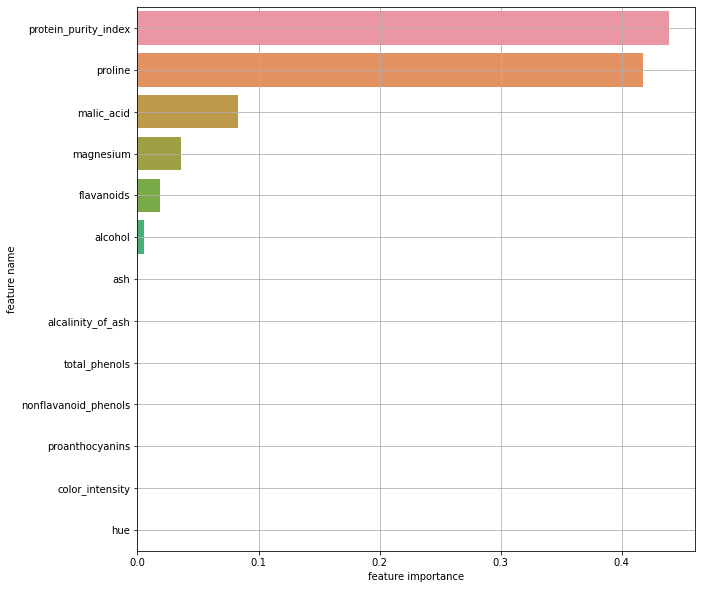

In [15]:
fig, ax = plt.subplots(figsize = (10, 10))
sns.barplot(data = df_feature_importance, y = "feature name", x = "feature importance", ax = ax)
plt.grid(which = "both")

## Scoring the decision tree
We can estimate the generalization capability of the decision tree classifier calling the 'score' methon on the testing set.
The default scoring metric we're going to use is 'accuracy', defined as the ratio of correct class prediction to the total predictions.

In [16]:
decision_tree.score(X_test, y_test)

0.8222222222222222

## Scatter plot considering the 2 most important features
Since we have stated that "flavonoids" and "proline" contents are the 2 most important features, we can try to represent the whole dataset in the scatter plot below, using the (x, y) axes for the identified features.

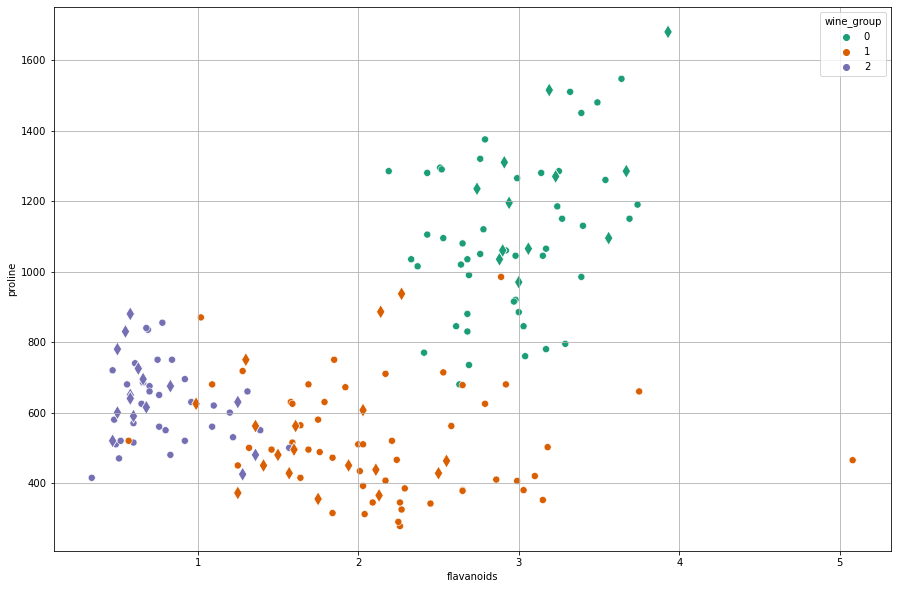

In [17]:
fig, ax = plt.subplots(figsize = (15, 10))

sns.scatterplot(x = X_train["flavanoids"], y = X_train["proline"], hue = y_train["wine_group"], 
            palette = "Dark2", ax = ax, marker = "o", s = 50, legend = False)
sns.scatterplot(x = X_test["flavanoids"], y = X_test["proline"], hue = y_test["wine_group"], 
            palette = "Dark2", ax = ax, marker = "d", s = 100, legend = True)
plt.grid(which = "both")


Looking at the plot above, we can see that couple "falvonoids" and "proline" characteristics make it easy to understand the 3 group or wines and their dispersion on the plane.
We can also notice that, while there seem to be a more intelligible dinstinction of the groups '0' and '1', there boundary ideally separating group '0' from group '1' is more difficult to understand.

Unfortunately, decision boundaries for classification trees are not as informative and 'beatiful', compared to the boundaries obtained with a support vector machine (SVM).

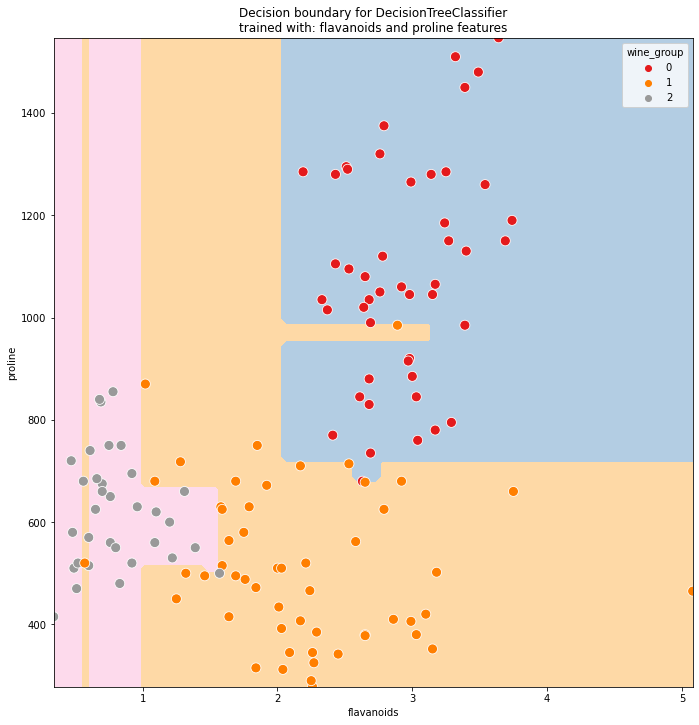

In [18]:
def plot_decison_boundary(model, X, y, feature_1, feature_2, n_points = 100):

    fig, ax = plt.subplots(figsize = (10, 10))
    x_min, x_max = X[feature_1].min(), X[feature_1].max()
    y_min, y_max = X[feature_2].min(), X[feature_2].max()
        
    pipeline = Pipeline([('scaler', MinMaxScaler()), ('model', model)])
    pipeline.fit(X[[feature_1, feature_2]].values, y.values)
    
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, n_points), np.linspace(y_min, y_max, n_points)
    )
    
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = pipeline.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    ax.contourf(xx, yy, Z, cmap=plt.get_cmap("Pastel1"), levels = len(np.unique(Z))-1) # the default plots len(Z) + 1 contour lines
    sns.scatterplot(x = X[feature_1], y = X[feature_2], s = 100, hue = y, palette = plt.get_cmap("Set1"))
    plt.title("Decision boundary for {}\ntrained with: {} and {} features".format(type(model).__name__, feature_1, feature_2))
    
plot_decison_boundary(decision_tree, X_train, y_train["wine_group"], "flavanoids", "proline")

As one can see from the plot above, the surface has piecewise linear boundaries due to the nature of the decision tree. The decision surface is not so informative and beautiful to see.

## Support Vector Machine
The goal of a support-vector machine constructs (SVM) is to build a hyperplane (or a set of hyperplanes multi-dimensional space), which is able to separate the groups of samples having the same class label. The mathematical model is fitted by maximizing the distance of the hyperplane from the nearest training-data point of any class. It's the so-called functional margin. The foundation of this strategy is that the larger the functional margin, the lower the generalization error of the classifier is expected to be.

For this tudy, we neclect the linear SVM wich is implemented in LinearSVC and assign the popular 'radial basis function' kernel to the model. This choice is justified because from the previous experiments, we can state that the classes are not linearly separable. One can look at the scatter plots for the 2 selected features, in the sections above.

So let's start by using the 'rbf' kernel and the 'balanced' class weight option, to take into account the data imbalance.


In [19]:
support_vector_machine = SVC(kernel = "rbf", class_weight = "balanced") # C and gamma are defined in the parameters space

From the 'sklearn' documentation, we can find out that there are 2 main hyperparameters for training the SVC model. They are the 'gamma' and 'C' parameters. The first one compares in the definitio of the kernel function and controls how far the influence of the individual point reaches. The larger the gamma, the more complex the decision boundary is; while with lower gamma, we impose a larger similarity radius, so data further apart are more likely to be grouped together. This leads to a smoother decision boundary.
The 'C' parameter controls the regularization: small C means higher regularization and viceversa.

The hyperparameters search will be performed for the set of (gamma, C) which values can range tipycally on a logarithmic space between 10^-5 and 10^+5. Note that the search space is discrete set of values.

In this study, I use the exhaustive grid-search method 'GridSearchCV' implemented in 'sklearn'. So the algorithm evaluates the hypermodel using all the possible combinations of hyperparameters, performs scores computation, and chooses the best one. Validation score is computed more times, using the embedded K-fold cross validation method and considering the average value of the validation score for each fold.

Pay attention that with a large, multi-dimensional search space, this method can be very time-consuming and computationally expensive, so other choices should be adopted. 

I first used a custom dictionary to define the parameters search in a readable way. Note that for each parameter, the set of values is a list of lists. This seems to be a redundant data format, but due to the implementation of 'ParameterGrid', I would get an error because each item of the parameters space has to be an iterable object. For this reason, there is the list comprehension here below.

After that, one can call the 'ParameterGrid' function and forcint its output to be an iterable object (a list!). 'ParameterGrid'is practically building a list of dictionaries that contain all possible combinations of the hyperparameters.

In [20]:
param_dict = {'C': [[x] for x in np.logspace(start = -5, stop = 5, num = 11)], 
              'gamma': [[x] for x in np.logspace(-6, 6, 13)]}

param_grid = list(ParameterGrid(param_dict))
print(param_grid[:5])

[{'C': [1e-05], 'gamma': [1e-06]}, {'C': [1e-05], 'gamma': [1e-05]}, {'C': [1e-05], 'gamma': [0.0001]}, {'C': [1e-05], 'gamma': [0.001]}, {'C': [1e-05], 'gamma': [0.01]}]


Note the param_grid structure: there is a list of dictionaries. In each dictionary, the keys are the hyperparameters names, and the values are now a list of numeric (but they could also be boolean, or string type) items.

Now we can launch the grid search, using the training sub-set as usual.

In [21]:
hypermodel = GridSearchCV(estimator = support_vector_machine, param_grid = param_grid, scoring = "accuracy")
hypermodel.fit(X_train_scaled, y_train["wine_group"])

GridSearchCV(estimator=SVC(class_weight='balanced'),
             param_grid=[{'C': [1e-05], 'gamma': [1e-06]},
                         {'C': [1e-05], 'gamma': [1e-05]},
                         {'C': [1e-05], 'gamma': [0.0001]},
                         {'C': [1e-05], 'gamma': [0.001]},
                         {'C': [1e-05], 'gamma': [0.01]},
                         {'C': [1e-05], 'gamma': [0.1]},
                         {'C': [1e-05], 'gamma': [1.0]},
                         {'C': [1e-05], 'gamma': [10.0]},
                         {'C': [1e-05], 'gamma': [100.0]},
                         {'C': [1e-05], 'gamma':...
                         {'C': [0.0001], 'gamma': [1.0]},
                         {'C': [0.0001], 'gamma': [10.0]},
                         {'C': [0.0001], 'gamma': [100.0]},
                         {'C': [0.0001], 'gamma': [1000.0]},
                         {'C': [0.0001], 'gamma': [10000.0]},
                         {'C': [0.0001], 'gamma': [100000.0]},
      

The best support vector machine is the one having the highest score.

In [22]:
best_svm = hypermodel.best_estimator_
best_params = hypermodel.best_params_
best_params, hypermodel.best_score_

({'C': 1.0, 'gamma': 1.0}, 0.9851851851851852)

In [23]:
best_svm.score(X_test_scaled, y_test["wine_group"])

0.9777777777777777

A note on the necessity of inputs scaling: SVMs are highly sensitive to features different magnitude. 

## Decision boundary of the SVC
Decision boundary have a more intelligible shape for support vector machines. In the figure below, I just called the previously defined function that accomplishes this task. Please note that the best model is passed as first argument (model). One can also specify other features.

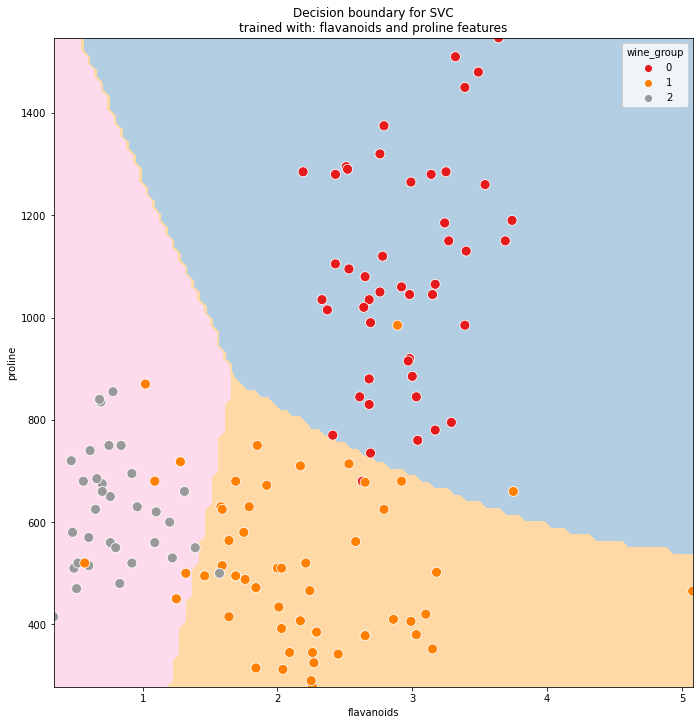

In [24]:
plot_decison_boundary(best_svm, X_train, y_train["wine_group"], "flavanoids", "proline")

From the picture above, we can distinguish a more defined, well-beaving decision surface. This is an advantage of SVMs on the decision trees.

Note that not all training data are located within the 'right' decision boundary. We could ask ourselves if the labels really have been correctly assigned to all wines...

## Logistic Regressor
Logistic regression, or equivalently logit classifier, is a linear model used for classification (not for regression!). 

In this  study, I used a particular implementation of the logit-regressor that applies cross validation methodology to fit sample data. Instead of using the default 'sklearn' class 'LogisticRegression' and than performing the hyperparameters tuning via the K-fold CV, the class 'LogisticRegressionCV' does it in one shot.

There is one principal hyperparameter to be tuned when using logit regressor, i.e. the 'C'. It's defined as the inverse of the regularization strength. Like in support vector machines, smaller values specify stronger regularization.

Keeping all other options (except the 'balanced' weights) as they are, the definition of the parameter search space is done while instantiating the hypermodel.

In [25]:
logit_model = LogisticRegressionCV(Cs = np.logspace(start = -4, stop = 4, num = 9), 
                                   scoring = "accuracy", class_weight = "balanced")

In [26]:
logit_model.fit(X_train_scaled, y_train["wine_group"])

LogisticRegressionCV(Cs=array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03,
       1.e+04]),
                     class_weight='balanced', scoring='accuracy')

## Plotting the validation curve for the logit regressor
The fitted hypermodel is a class with several attributes. We can retrieve the array of 'C' values and average the scores on the K folds. This allows us to select the best parameter configuration, simply by looking at the validation curve below.

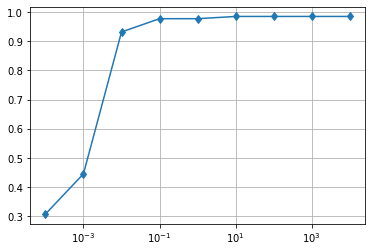

In [27]:
plt.semilogx(logit_model.Cs_, np.mean(logit_model.scores_[0], axis =0), marker = "d")
plt.grid(which = "both")

## Assess the generalization capability
Finally, the model generalization capability can be evaluated by calling the 'score' function and providing the testing sub-set.

In [28]:
logit_model.score(X_test_scaled, y_test["wine_group"])

1.0

But one could also predict and then score the model separately. For example, one could now look at a different scoring metric.

In [29]:
y_pred = logit_model.predict(X_test_scaled)
y_pred = pd.DataFrame(y_pred, columns = y_train.columns)

print(accuracy_score(y_test.values, y_pred.values))

1.0


## Decision boundary of the logit regressor
As previously done for the other models, we can call the custom function 'plot_decision_boundary' again and look at the outcomes.

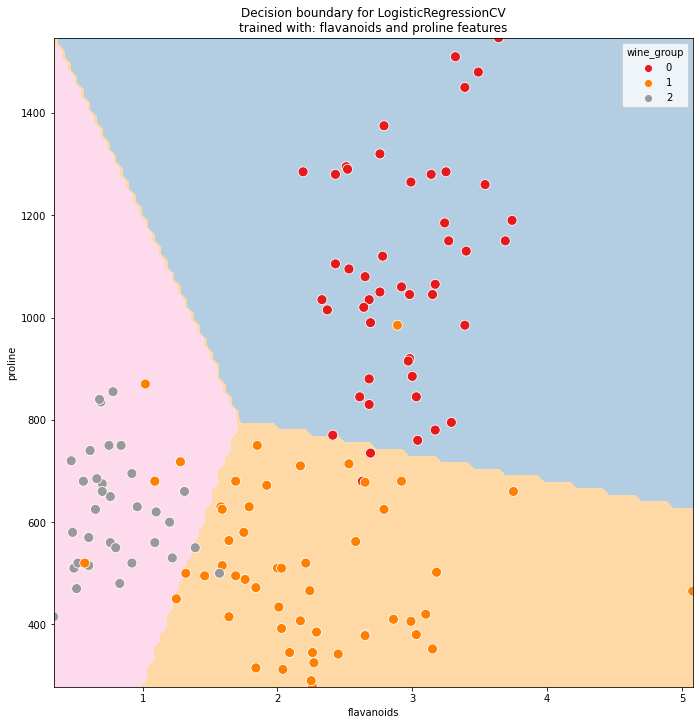

In [30]:
plot_decison_boundary(logit_model, X_train, y_train["wine_group"], "flavanoids", "proline")

## References
Asuncion, A. & Newman, D.J. (2007). UCI Machine Learning Repository [http://www.ics.uci.edu/~mlearn/MLRepository.html]. Irvine, CA: University of California, School of Information and Computer Science.